# Individual Household Electric Power Consumption

## Jon Davidson and Nathan Dorsey

## About the Data

For this analysis, we aimed to develop a neural network capable of predicting and optimizing household energy consumption to reduce peak electricity usage and improve energy efficiency. This dataset contains approximately 2,000,000 entries, capturing various metrics related to household electric power usage from December 2006 to November 2010. Our goal was to use this data to predict hourly, daily, weekly, and monthly energy usage patterns and identify opportunities for reducing high consumption to enhance overall efficiency.

## Importing Libraries

Before beginning analysis, it is crucial to load all packages required to perform an analysis. Pandas is essential for loading and processing the dataset, and creating new features that might be necessary. Sklearn provides multiple tools enabling the analysis: train_test_split, MinMaxScaler, mean_squared_error, and permutation_importance. train_test_split enables use to split the dataset into training and testing sets to evaluate the model performance. MinMaxScaler is used to ensure that all features are on a similar scale, ensuring similar weight of features. We used mean_squared_error to measure the model's error between predicted and actual data. permutation_importance is used to measure the importance of each feature. Our main tool, TensorFlow, is used to design and train the neural network predicting energy consumption based on the features.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

## Loading the Data

We loaded our data using Pandas, adding many hyperparameters needed to load the data in a usable format and prevent loading errors from affecting the presentation of the analysis. In the dataset, each metric is separated by a semicolon, so we identified it when loading.

In [ ]:
#Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/household_power_consumption.txt',
    sep=';',                   # Specify delimiter
    parse_dates={'Datetime': ['Date', 'Time']},  # Ensure correct loading through combining
    infer_datetime_format=True,  # Ensure datetime format
    na_values=['NaN'],             # Identify missing values
    low_memory=False             # Avoid dtype warnings
)

# Display first few rows
print(df.head())

<ipython-input-2-9fb265a5ad75>:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/household_power_consumption.txt',
<ipython-input-2-9fb265a5ad75>:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/household_power_consumption.txt',
<ipython-input-2-9fb265a5ad75>:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/household_power_consumption.txt',


             Datetime Global_active_power Global_reactive_power  Voltage  \
0 2006-12-16 17:24:00               4.216                 0.418  234.840   
1 2006-12-16 17:25:00               5.360                 0.436  233.630   
2 2006-12-16 17:26:00               5.374                 0.498  233.290   
3 2006-12-16 17:27:00               5.388                 0.502  233.740   
4 2006-12-16 17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0  


## Data Cleaning and Preprocessing

We removed the errors and excluded them from the dataset. Since the N/A values account for only about 1% of the data, eliminating them helps avoid potential bias while having a negligible impact on the overall dataset.

In [ ]:
#Check missing values
print(df.isnull().sum())

#Missing values in Sub_metering_3 divided by total observations
print(df['Sub_metering_3'].isnull().sum()/df.shape[0])

#Remove missing values from Sub_metering_3
df = df.dropna(subset=['Sub_metering_3'])

#Ensure values eliminated
print(df.isnull().sum())

Datetime                     0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64
0.012518437457686004


## Ensure Correct Datatypes

In [ ]:
#Correct datatypes
print(df.dtypes)

To ensure the correct datatypes, we change the power recordings from object to float64, making the metrics usable for analysis.

In [ ]:
# Convert object datatypes to float64
df['Global_active_power'] = df['Global_active_power'].astype('float64')
df['Global_reactive_power'] = df['Global_reactive_power'].astype('float64')
df['Voltage'] = df['Voltage'].astype('float64')
df['Global_intensity'] = df['Global_intensity'].astype('float64')
df['Sub_metering_1'] = df['Sub_metering_1'].astype('float64')
df['Sub_metering_2'] = df['Sub_metering_2'].astype('float64')
df['Sub_metering_3'] = df['Sub_metering_3'].astype('float64')

#Ensure correct datatypes
print(df.dtypes)

Datetime                 datetime64[ns]
Global_active_power              object
Global_reactive_power            object
Voltage                          object
Global_intensity                 object
Sub_metering_1                   object
Sub_metering_2                   object
Sub_metering_3                  float64
dtype: object
Datetime                 datetime64[ns]
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
dtype: object


## Feature Engineering

We created hour, day, month, year, and weekday features to predict and optimize energy usage over all increments of time. Hour serves to predict when energy usage occurs during specific times of the day, such as mornings or evenings, optimizing daily spikes. Day and Weekday helps the model capture patterns across different days of the month or week. Breaking down month and years will help the model learn how energy usage varies by season or even longer periods.

In [ ]:
#Separate datetime to analyze hourly and daily trends
df['Hour'] = df['Datetime'].dt.hour
df['Day'] = df['Datetime'].dt.day
df['Month'] = df['Datetime'].dt.month
df['Year'] = df['Datetime'].dt.year
df['Weekday'] = df['Datetime'].dt.dayofweek

#Display first few rows
df.head()

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Hour,Day,Month,Year,Weekday
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,17,16,12,2006,5
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,17,16,12,2006,5
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,17,16,12,2006,5
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,17,16,12,2006,5
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,17,16,12,2006,5


## Analysis

Now, we will design and implement a neural network to predict and optimize energy consumption, aiming to reduce usage spikes and, consequently lower energy costs.

First, we'll setup the features and target, then normalize the features, so that the scale of data does not impact our results.

In [ ]:
# Define features
features = ['Hour', 'Day', 'Month', 'Year', 'Weekday', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

In [ ]:
# Define features and target
X = df[features]
y = df['Global_active_power']  # Target variable: Energy consumption

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

From there, we setup the neural network. While 64 neurons is a common choice for the first hidden layer, we chose this number to balance model complexity and performance. Adding too many neurons could lead to overfitting, which would negatively impact our results. The first hidden layer builds on the input features aiming to capture a wide range of patterns in the data. The second hidden layer, with 32 neurons, helps refine the representation of these patterns. Finally, the output layer consists of one neuron predicting the energy consumption.

In [ ]:
# Define the neural network model
model = tf.keras.Sequential()

# Input layer (number of input features)
model.add(tf.keras.layers.Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))

# Hidden layers
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))

# Output layer (single value prediction for regression)
model.add(tf.keras.layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,041 (27.50 KB)

 Trainable params: 7,041 (27.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
40986/40986 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - loss: 0.0246 - val_loss: 0.0011
Epoch 2/10
40986/40986 ━━━━━━━━━━━━━━━━━━━━ 88s 2ms/step - loss: 0.0013 - val_loss: 9.9406e-04
Epoch 3/10
40986/40986 ━━━━━━━━━━━━━━━━━━━━ 145s 2ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 4/10
40986/40986 ━━━━━━━━━━━━━━━━━━━━ 93s 2ms/step - loss: 0.0011 - val_loss: 9.9048e-04
Epoch 5/10
40986/40986 ━━━━━━━━━━━━━━━━━━━━ 88s 2ms/step - loss: 0.0010 - val_loss: 9.2491e-04
Epoch 6/10
40986/40986 ━━━━━━━━━━━━━━━━━━━━ 88s 2ms/step - loss: 9.9468e-04 - val_loss: 9.7684e-04
Epoch 7/10
40986/40986 ━━━━━━━━━━━━━━━━━━━━ 90s 2ms/step - loss: 9.7152e-04 - val_loss: 8.5725e-04
Epoch 8/10
40986/40986 ━━━━━━━━━━━━━━━━━━━━ 88s 2ms/step - loss: 9.5838e-04 - val_loss: 0.0010
Epoch 9/10
40986/40986 ━━━━━━━━━━━━━━━━━━━━ 166s 3ms/step - loss: 9.4732e-04 - val_loss: 8.8913e-04
Epoch 10/10
40986/40986 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step - loss: 9.3070e-04 - val_loss: 8.4292e-04


In [ ]:
# Evaluate the model on the test data
loss = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss: {loss}')

12808/12808 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 8.3802e-04
Test Loss: 0.0008419642108492553


In [ ]:
# Predict on the test data
y_pred = model.predict(X_test_scaled)

# Example: comparing first few predicted vs actual values
for i in range(10):
    print(f"Predicted: {y_pred[i]}, Actual: {y_test.values[i]}")

12808/12808 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
Predicted: [1.5431299], Actual: 1.502
Predicted: [0.3882081], Actual: 0.374
Predicted: [0.64575136], Actual: 0.62
Predicted: [0.27520496], Actual: 0.28
Predicted: [1.365411], Actual: 1.372
Predicted: [0.30385196], Actual: 0.284
Predicted: [0.16313966], Actual: 0.196
Predicted: [2.2272754], Actual: 2.234
Predicted: [0.47573775], Actual: 0.486
Predicted: [1.8340685], Actual: 1.842


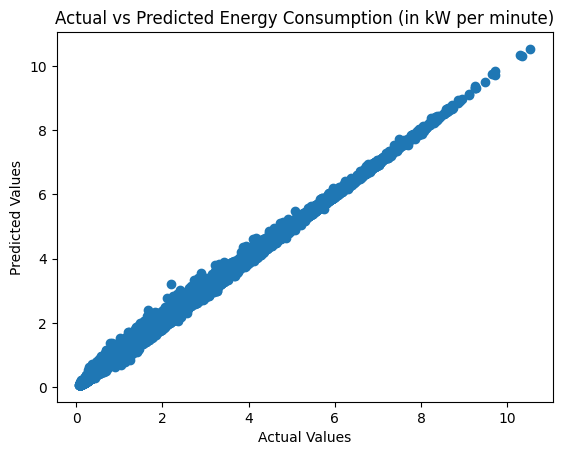

In [ ]:
# Plot actual vs predicted
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Energy Consumption (in kW per minute)')
plt.show()

As we can see from the first few predicted test values, as well as the correlation graph, the model is performing very well. The model's predictions on the test data also suggest that the model is not overfitting and is generalizing well to new data.

Next, we'll analyze the feature importance to dig a bit deeper into the model and see what is contributing the most to the model's predictions, allowing us to make some more generalizations of the model. We'll use SHAP (Shapley additive explanations) to do so.

In [ ]:
# Define a custom scoring function for MSE
def custom_scorer(model, X, y):
    # Make predictions with your Keras model
    y_pred = model.predict(X)
    # Calculate and return MSE
    return -mean_squared_error(y, y_pred)  # Return negative because lower MSE is better

# Compute permutation importance
X_test_sample = X_test_scaled[:500]  # Use 500 samples instead of 12,808
y_test_sample = y_test[:500]

perm_importance = permutation_importance(
    model, X_test_sample, y_test_sample,
    scoring=custom_scorer,
    n_repeats=5,
    random_state=42,
    # n_jobs=-1  # Use all available CPU cores
)

# Extract feature importances and their indices
sorted_importances_idx = perm_importance.importances_mean.argsort()

# Print the importance of each feature
for i in sorted_importances_idx[::-1]:  # reverse order for descending
    print(f"Feature: {features[i]}, Importance: {perm_importance.importances_mean[i]}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Trivially, and as expected, the most important features contributing to the total usage correlate highly with it and are closely related. For instance, global intensity, which is measured in amperes, stands out as the most influential variable. While this result is intuitive, as power consumption in amperes directly reflects the electrical load on the household, and consequently, the energy consumed, it could suggest that staggering high-energy tasks -- like running the dishwasher, washing machine, or other large appliances at different times -- could help reduce overall energy usage.

However, if we look at some of the other features, such as sub metering 3, corresponding to an electric water heater and air conditioner, has more importance than sub meterings one and two, suggesting that water heating and air conditioning have a greater impact on overall energy consumption, providing insight on the most important aspects of controlling and optimizing energy.

We can also see that while day, weekday, and year are less important, of the time data, hour and month seem to be the most important, suggesting that peak usage could depend on the time of day, giving us more insight into how a household could better optimize energy consumption by paying attention to what time of day they use what appliances and utilities, especially relating back to air conditioning; if the air conditioning is consistently turned up high during the peak hours of the day, for example, one could consider turning the AC off or down during these hours or maintaining a more steady but slightly warmer temperature, controlling for big fluctuations throughout the day which drive up energy usage substantially.

## Additional Discussion
Beyond feature importance, the model offers key insights that contribute directly to the goal of predicting and optimizing household energy consumption. One important aspect of this model is its ability to detect patterns and forecast energy consumption spikes, allowing for informed, data-driven decisions. By analyzing the relationships between time-based features, such as Hour and Month, alongside power-related variables like Global_intensity, the model can identify recurring patterns in energy usage. This capability enables households to anticipate when their energy consumption will likely spike, whether on a daily basis, such as during peak hours, or seasonally, like in the summer when air conditioning use is high.

Such foresight allows for proactive energy management, where households can plan ahead and shift high-consumption activities to non-peak times, ultimately leading to more efficient energy usage. For example, if the model predicts that energy consumption will peak in the afternoon during warmer months, homeowners can adjust their thermostat settings to pre-cool their homes during off-peak hours or delay running high-energy appliances like dishwashers or washing machines until after peak hours.

Moreover, the model provides an opportunity to detect anomalies in energy usage that may otherwise go unnoticed. By comparing predicted energy usage to actual consumption, the model can highlight unexpected spikes that might indicate inefficiencies, such as malfunctioning appliances or other abnormal patterns. For instance, if a water heater or HVAC system suddenly begins to draw more power than usual, the model can flag this as an anomaly. This insight allows for early detection of potential issues, prompting households to address inefficiencies before they result in significantly higher energy bills. This predictive capability further enhances energy optimization by enabling real-time intervention and preventing wasteful consumption.

Finally, the model’s predictive power can be leveraged to simulate different energy usage scenarios, providing households with a tool to evaluate the impact of behavioral changes on overall consumption. By adjusting input features—such as turning off non-essential devices during peak times or modifying heating and cooling patterns—the model can predict the effect of these changes on total energy usage. This allows households to test various strategies and make informed decisions about the most effective methods to reduce consumption and costs.

## Conclusion
This model provides a comprehensive tool for households aiming to manage and optimize their energy consumption. Its ability to predict consumption spikes, detect anomalies, and simulate various usage scenarios empowers users to take proactive steps toward more efficient energy usage. By anticipating high-demand periods and identifying inefficiencies early, households can make targeted adjustments—whether through shifting appliance use to off-peak times, adjusting temperature controls, or addressing malfunctioning equipment. This not only helps reduce overall energy consumption but also allows for more strategic, cost-saving decisions. Ultimately, the model delivers actionable insights that address the core challenge of optimizing electricity usage, making it a valuable asset for both daily household management and long-term energy efficiency planning